In [ ]:
import numpy as np 
import pandas as pd
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/MyDrive/'
base_path_val='/content/drive/MyDrive/BTP Hate Speech 2022_23/'

In [ ]:
train_df=pd.read_json('/content/drive/MyDrive/BTP Hate Speech 2022_23/dataset/faceebook memes dataset/data/train_with_caption.json')
val_df=pd.read_json('/content/drive/MyDrive/BTP Hate Speech 2022_23/dataset/faceebook memes dataset/data/val_with_caption.json')
test_df=pd.read_json('/content/drive/MyDrive/BTP Hate Speech 2022_23/dataset/faceebook memes dataset/data/test.json',lines=True)

In [ ]:
train_df.head()

,id,img,label,text,capt_text
0,42953,img/42953.png,0,its their character not their color that matters,a man with a black and white photo of him
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,a woman in a suit and tie is reading a newspaper
2,13894,img/13894.png,0,putting bows on your pet,a cat sitting on a red tie
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,a dog with a picture of a dog on it's face
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",a man in a suit talking on a cell phone


In [ ]:
train_df['label'].value_counts()

0    5450
1    3050
Name: label, dtype: int64

<Axes: >

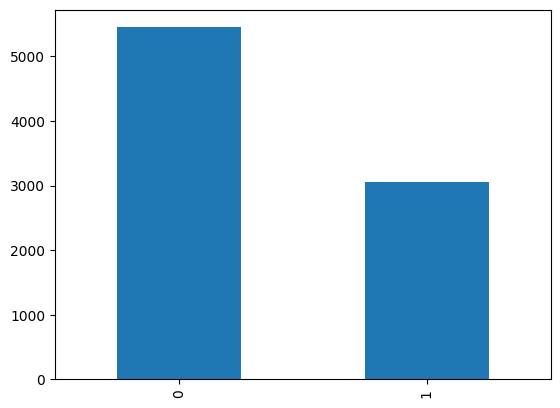

In [ ]:
train_df['label'].value_counts().plot(kind="bar")

<Axes: >

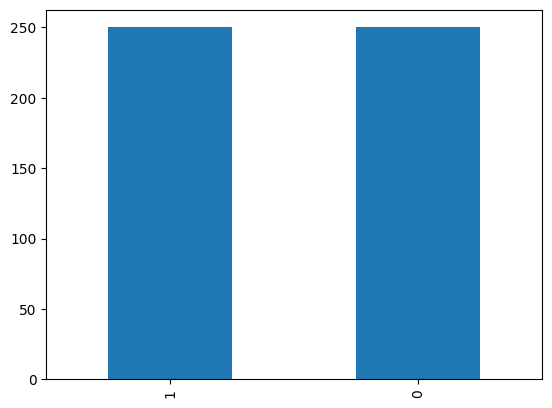

In [ ]:
val_df['label'].value_counts().plot(kind="bar")

In [ ]:
# !pip install tqdm

In [ ]:
# !pip install pytorch-transformers

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, VisualBertModel
import tqdm

In [ ]:
# device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
batch_size = 64
epochs = 10
LEARNING_RATE = 1e-05

In [ ]:
# model = VisualBertModel.from_pretrained("uclanlp/visualbert-nlvr2-coco-pre")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 10 07:21:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    24W / 300W |      2MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch. __version__

'2.0.0+cu118'

In [ ]:
def get_visual_embeddings(path):
    embeds = torch.load(path)
    return embeds

In [ ]:
class HateDataset(Dataset):
    def __init__(self,dataframe):
        self.df = dataframe
    
    def __getitem__(self,index):
        text = f'The photo is of {self.df.capt_text[index]}. It contains text {self.df.text[index]}'
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding='max_length',max_length=100)
#         print(inputs['input_ids'].shape)
        visual_embeds = get_visual_embeddings(f"{base_path}visualembeddings/{self.df.id[index]}.pt")
        visual_token_type_ids = torch.ones([1,visual_embeds.shape[0]], dtype=torch.long)
        visual_attention_mask = torch.ones([1,visual_embeds.shape[0]], dtype=torch.float)
        inputs.update(
            {
                "visual_embeds": visual_embeds,
                "visual_token_type_ids": visual_token_type_ids,
                "visual_attention_mask": visual_attention_mask
            }
        )
        inputs['input_ids']=torch.flatten(inputs['input_ids'])
        inputs['attention_mask']=torch.flatten(inputs['attention_mask'])
        inputs['token_type_ids']=torch.flatten(inputs['token_type_ids'])
        inputs['visual_attention_mask']=torch.flatten(inputs['visual_attention_mask'])
        inputs['visual_token_type_ids']=torch.flatten(inputs['visual_token_type_ids'])
        return inputs, self.df.label[index]
    
    def __len__(self):
        return len(self.df)

In [ ]:
class HateDatasetVal(Dataset):
    def __init__(self,dataframe):
        self.df = dataframe
    
    def __getitem__(self,index):
        text = f'The photo is of {self.df.capt_text[index]}. It contains text {self.df.text[index]}'
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding='max_length',max_length=100)
#         print(inputs['input_ids'].shape)
        visual_embeds = get_visual_embeddings(f"{base_path_val}visualembeddings/{self.df.id[index]}.pt")
        visual_token_type_ids = torch.ones([1,visual_embeds.shape[0]], dtype=torch.long)
        visual_attention_mask = torch.ones([1,visual_embeds.shape[0]], dtype=torch.float)
        inputs.update(
            {
                "visual_embeds": visual_embeds,
                "visual_token_type_ids": visual_token_type_ids,
                "visual_attention_mask": visual_attention_mask
            }
        )
        inputs['input_ids']=torch.flatten(inputs['input_ids'])
        inputs['attention_mask']=torch.flatten(inputs['attention_mask'])
        inputs['token_type_ids']=torch.flatten(inputs['token_type_ids'])
        inputs['visual_attention_mask']=torch.flatten(inputs['visual_attention_mask'])
        inputs['visual_token_type_ids']=torch.flatten(inputs['visual_token_type_ids'])
        return inputs, self.df.label[index]
    
    def __len__(self):
        return len(self.df)

In [ ]:
train_ds = HateDataset(train_df)
val_ds = HateDatasetVal(val_df)
test_ds = HateDatasetVal(test_df)

In [ ]:
train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=64, shuffle=True)

In [ ]:
# for X,y in val_dataloader:
#     print(X)
#     print(y)
#     break

In [ ]:
class VisualBertClass(nn.Module):
    def __init__(self):
        super(VisualBertClass, self).__init__()
        self.l1 = VisualBertModel.from_pretrained("uclanlp/visualbert-nlvr2-coco-pre")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 2)
        self.res=torch.nn.Softmax()

    def forward(self, input_ids, attention_mask, token_type_ids, visual_embeds, visual_attention_mask, visual_token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, visual_embeds=visual_embeds, visual_attention_mask=visual_attention_mask, visual_token_type_ids=visual_token_type_ids)
#         hidden_state = output_1.last_hidden_state
#         pooler = hidden_state[:, 0]
        pooler=output_1.pooler_output
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        res=self.res(output)
        return res

In [ ]:
model_fn = VisualBertClass()
model_fn.to(device)

Some weights of the model checkpoint at uclanlp/visualbert-nlvr2-coco-pre were not used when initializing VisualBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing VisualBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing VisualBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


VisualBertClass(
  (l1): VisualBertModel(
    (embeddings): VisualBertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (visual_token_type_embeddings): Embedding(2, 768)
      (visual_position_embeddings): Embedding(512, 768)
      (visual_projection): Linear(in_features=1024, out_features=768, bias=True)
    )
    (encoder): VisualBertEncoder(
      (layer): ModuleList(
        (0-11): 12 x VisualBertLayer(
          (attention): VisualBertAttention(
            (self): VisualBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): 

In [ ]:
weights=torch.tensor([1, 1.8])
weights=weights.to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)
optimizer_fn = torch.optim.Adam(params =  model_fn.parameters(), lr=LEARNING_RATE)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    correct = 0
    total = 0
    hate_correct= 0
    final_act=[]
    final_pred=[]
    for batch,(X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(input_ids=X['input_ids'], attention_mask=X['attention_mask'], token_type_ids=X['token_type_ids'], visual_embeds=X['visual_embeds'], visual_attention_mask=X['visual_attention_mask'], visual_token_type_ids=X['visual_token_type_ids'])
        loss = loss_fn(pred, y)
        # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        big_val, big_idx = torch.max(pred.data, dim=1)
        correct+=(big_idx==y).sum().item()
        total += pred.shape[0]
        y_pred=pred.detach().cpu().numpy().tolist()
        y_act=y.detach().cpu().numpy().tolist()
        y_act_dim2=[]
        for tx,ty in zip(y_pred,y_act):
          if ty==0:
            y_act_dim2.append([1,0])
          else:
            y_act_dim2.append([0,1])
            if tx[0]<=tx[1]:
              hate_correct+=1
        final_act.extend(y_act_dim2)
        final_pred.extend(y_pred)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss, current = loss.item(), (batch + 1) * pred.shape[0]
        roc_auc = metrics.roc_auc_score(final_act,final_pred)
        if batch%100==0:
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
          print(f"Intermediate Accuracy is:{correct/total}")
    roc_auc = metrics.roc_auc_score(final_act,final_pred)
    print("--------------------Metrics for Training Dataset--------------------")
    print(f"No. of correct examples are {correct}. Size is {size} ")
    print(f"No. of correctly identified hate tweets are: {hate_correct}")
    print(f"AUROC score on training dataset is: {roc_auc}")
    print("Accuracy is: ", correct/total)
    print("--------------------End--------------------")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    test_pred=torch.empty(0,2,device='cuda')
    hate_correct= 0
    final_act=[]
    final_pred=[]
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(input_ids=X['input_ids'].squeeze(0), attention_mask=X['attention_mask'], token_type_ids=X['token_type_ids'], visual_embeds=X['visual_embeds'], visual_attention_mask=X['visual_attention_mask'], visual_token_type_ids=X['visual_token_type_ids'])
            test_pred=torch.cat([test_pred,pred],dim=0)
            test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            big_val, big_idx = torch.max(pred.data, dim=1)
            correct+=(big_idx==y).sum().item()
            y_pred=pred.detach().cpu().numpy().tolist()
            y_act=y.detach().cpu().numpy().tolist()
            y_act_dim2=[]
            for tx,ty in zip(y_pred,y_act):
              if ty==0:
                y_act_dim2.append([1,0])
              else:
                y_act_dim2.append([0,1])
                if tx[0]<=tx[1]:
                  hate_correct+=1
            final_act.extend(y_act_dim2)
            final_pred.extend(y_pred)
    roc_auc = metrics.roc_auc_score(final_act,final_pred)
    print("--------------------Metrics for Test Dataset--------------------")
    print(f"No. of correct examples are {correct}. Size is {size} ")
    print(f"No. of correctly identified hate tweets are: {hate_correct}")
    print(f"AUROC score on valid dataset is: {roc_auc}")
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print("--------------------END--------------------")

In [ ]:
epochs=2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_fn, loss_fn, optimizer_fn)
    test(val_dataloader, model_fn, loss_fn)
# test(test_dataloader, model_fn, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.313495  [   64/ 8500]
Intermediate Accuracy is:1.0
loss: 0.433082  [ 6464/ 8500]
Intermediate Accuracy is:0.9175433168316832
--------------------Metrics for Training Dataset--------------------
No. of correct examples are 7809. Size is 8500 
No. of correctly identified hate tweets are: 2780
AUROC score on training dataset is: 0.9255999097608663
Accuracy is:  0.9187058823529411
--------------------End--------------------
--------------------Metrics for Test Dataset--------------------
No. of correct examples are 306. Size is 500 
No. of correctly identified hate tweets are: 89
AUROC score on valid dataset is: 0.635292
Test Error: 
 Accuracy: 61.2%, Avg loss: 0.770276 

--------------------END--------------------
Epoch 2
-------------------------------
loss: 0.396813  [   64/ 8500]
Intermediate Accuracy is:0.9375
loss: 0.327540  [ 6464/ 8500]
Intermediate Accuracy is:0.9201732673267327
--------------------Metrics for Training Dataset-------

In [ ]:
# inputs = tokenizer("its their character not their color that matters", return_tensors="pt")
# print(inputs['attention_mask'].shape)

In [ ]:
print(test_pred)

In [ ]:
# visual_embeds = get_visual_embeddings(f"{base_path}visualembeddings/42953.pt")
# visual_attention_mask = torch.ones([1,visual_embeds.shape[0]], dtype=torch.float)
# visual_token_type_ids = torch.ones([1,visual_embeds.shape[0]], dtype=torch.long)
# inputs.update(
#     {
#         "visual_embeds": visual_embeds,
#         "visual_token_type_ids": visual_token_type_ids,
#         "visual_attention_mask": visual_attention_mask,
#     }
# )
# outputs = model(**inputs)
# print(outputs)

In [ ]:
# torch.save(model_fn.state_dict(), f"{base_path}visualbertmodel1.pth")
torch.save(model_fn.state_dict(), f"visualbertmodel2.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
# # To load model
model_fn = VisualBertClass()
model_fn.load_state_dict(torch.load(f"{base_path}visualbertmodel1.pth"),strict=False)

Some weights of the model checkpoint at uclanlp/visualbert-nlvr2-coco-pre were not used when initializing VisualBertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing VisualBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing VisualBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
# base_path='/content/drive/MyDrive/BTP Hate Speech 2022_23/'
# test(val_dataloader, model_fn, loss_fn)

torch.Size([64, 100])


<ipython-input-21-3889b0946e94>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  res=self.res(output)


torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([64, 100])
torch.Size([52, 100])
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.696777 



In [ ]:
# model_fn=model_fn.to('cuda')

In [ ]:
test_pred=torch.empty(0,2,device='cuda')

In [ ]:
from sklearn.metrics import RocCurveDisplay